# 03 - LSTM Model
## TCI6313 Computational Intelligence Project
### Long Short-Term Memory Network for Time-Series Air Quality Prediction

---

**Objective:** Implement LSTM to capture temporal dependencies in air quality data.

**Model Type:** LSTM (Long Short-Term Memory) Recurrent Neural Network

**CI Justification:**
- LSTMs are a specialized form of RNN (Recurrent Neural Network)
- Designed to learn long-term dependencies through gating mechanisms
- Particularly suited for time-series data where past values influence future
- Air quality follows temporal patterns (rush hours, daily cycles, seasons)

In [23]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
from datetime import datetime
import time

# Add src to path
sys.path.append(os.path.abspath('../src'))

# Import custom modules
from preprocessing import prepare_data_for_lstm, inverse_transform_predictions
from lstm_model import LSTMModel, create_lstm_model, train_and_evaluate_lstm
from evaluation import (
    evaluate_model, compute_rmse, compute_mae,
    plot_actual_vs_predicted, plot_residuals, plot_training_history,
    print_evaluation_summary, save_results_to_json
)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Display current time
print("="*60)
print(f"🕒 Current Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)
print("Libraries and modules imported successfully!")


🕒 Current Time: 2026-01-10 13:36:09
Libraries and modules imported successfully!


## 1. Data Preprocessing for LSTM

LSTM requires sequential input data. We use sliding windows to create sequences.

**Sequence Length = 12** (using past 12 hours to predict next hour)

**Note:** Sequence length is 12 hours - a reasonable compromise for capturing daily patterns while keeping training manageable.

In [24]:
# Configuration
DATA_PATH = '../data/AirQuality.csv'
TARGET_COLUMN = 'C6H6(GT)'
SEQUENCE_LENGTH = 12  # Reduced from 24 for faster training
TEST_SIZE = 0.15
VAL_SIZE = 0.15

print("="*60)
print(f"🕒 Data Loading Started: {datetime.now().strftime('%H:%M:%S')}")
print("="*60)

start_time = time.time()

# Preprocess data for LSTM
data = prepare_data_for_lstm(
    filepath=DATA_PATH,
    target_column=TARGET_COLUMN,
    sequence_length=SEQUENCE_LENGTH,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
    scaler_type='standard',
    random_state=RANDOM_SEED
)

load_time = time.time() - start_time
print(f"\n✓ Data loaded in {load_time:.2f} seconds")
print(f"🕒 Completed at: {datetime.now().strftime('%H:%M:%S')}")
print("="*60)


🕒 Data Loading Started: 13:36:09
PREPROCESSING PIPELINE FOR LSTM
[INFO] Loaded dataset with shape: (9357, 15)
[INFO] Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
[INFO] Created datetime features. New shape: (9357, 23)
[INFO] Missing values before handling: 16701
[INFO] Missing values after handling: 0
[INFO] Final shape after handling missing values: (924, 23)
[INFO] Selected 18 features: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos']
[INFO] Target variable: C6H6(GT)
[INFO] Data split completed:
       Train: 646 samples (69.9%)
       Validation: 139 samples (15.0%)
       Test: 139 samples (15.0%)
[INFO] Data scaled using standard scaler
[INFO] Feature range after scaling - mean

In [25]:
# Extract data
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nSequence shape: {X_train.shape}")
print(f"  - Samples: {X_train.shape[0]}")
print(f"  - Time steps: {X_train.shape[1]}")
print(f"  - Features: {X_train.shape[2]}")

Training samples: 634
Validation samples: 127
Test samples: 127

Sequence shape: (634, 12, 18)
  - Samples: 634
  - Time steps: 12
  - Features: 18


## 2. LSTM Model Architecture

### Why LSTM for Air Quality?

1. **Temporal Patterns**: Pollution levels follow daily cycles (rush hours)
2. **Long-term Dependencies**: Weather effects can persist for hours
3. **Sequential Nature**: Current air quality depends on previous hours

### Architecture Design (Standard Configuration):
- **LSTM Layers**: 2 layers (64, 32 units) - same complexity as ANN
- **Dense Layers**: 1 layer (32 neurons) - matches ANN output layer
- **Dropout**: 0.2 for regularization
- **Recurrent Dropout**: 0.1 for temporal regularization

**Note:** This configuration matches ANN baseline for **fair comparison**.

In [26]:
# Model Configuration (STANDARD - for fair comparison)
MODEL_CONFIG = {
    'lstm_layers': [64, 32],    # Two layers like ANN baseline
    'dense_layers': [32],       # Same as ANN
    'learning_rate': 0.001,
    'dropout_rate': 0.2,
    'recurrent_dropout': 0.1,
    'bidirectional': False
}

# Training Configuration (STANDARD - matches ANN baseline)
TRAIN_CONFIG = {
    'epochs': 100,              # Same as ANN
    'batch_size': 32,           # Same as ANN
    'early_stopping_patience': 15  # Same as ANN
}

print("="*60)
print("⚙️  MODEL CONFIGURATION (STANDARD - Fair Comparison)")
print("="*60)
for k, v in MODEL_CONFIG.items():
    print(f"  {k}: {v}")
print("\n🏃 TRAINING CONFIGURATION")
print("-"*60)
for k, v in TRAIN_CONFIG.items():
    print(f"  {k}: {v}")
print("="*60)
print("\n📊 Configuration matched with ANN Baseline for fair comparison:")
print("  ✓ Epochs: 100 (same as ANN)")
print("  ✓ Batch size: 32 (same as ANN)")
print("  ✓ Architecture: [64, 32] + [32] (similar to ANN)")
print("  ✓ Early stopping: 15 epochs patience")
print("="*60)

⚙️  MODEL CONFIGURATION (STANDARD - Fair Comparison)
  lstm_layers: [64, 32]
  dense_layers: [32]
  learning_rate: 0.001
  dropout_rate: 0.2
  recurrent_dropout: 0.1
  bidirectional: False

🏃 TRAINING CONFIGURATION
------------------------------------------------------------
  epochs: 100
  batch_size: 32
  early_stopping_patience: 15

📊 Configuration matched with ANN Baseline for fair comparison:
  ✓ Epochs: 100 (same as ANN)
  ✓ Batch size: 32 (same as ANN)
  ✓ Architecture: [64, 32] + [32] (similar to ANN)
  ✓ Early stopping: 15 epochs patience


In [27]:
# Create LSTM Model
lstm_model = LSTMModel(
    sequence_length=SEQUENCE_LENGTH,
    n_features=data['n_features'],
    lstm_layers=MODEL_CONFIG['lstm_layers'],
    dense_layers=MODEL_CONFIG['dense_layers'],
    learning_rate=MODEL_CONFIG['learning_rate'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    recurrent_dropout=MODEL_CONFIG['recurrent_dropout'],
    bidirectional=MODEL_CONFIG['bidirectional'],
    random_seed=RANDOM_SEED
)

# Build the model
lstm_model.build()

[INFO] Building LSTM model...

LSTM MODEL ARCHITECTURE


Model: "LSTM_TimeSeries"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,881 (136.25 KB)

 Trainable params: 34,817 (136.00 KB)

 Non-trainable params: 64 (256.00 B)

## 3. Model Training

In [28]:
# Train the model
print("="*60)
print("🚀 TRAINING STARTED")
print("="*60)
print(f"🕒 Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📊 Training samples: {X_train.shape[0]}")
print(f"📊 Validation samples: {X_val.shape[0]}")
print(f"⚙️  Epochs: {TRAIN_CONFIG['epochs']}")
print(f"⚙️  Batch size: {TRAIN_CONFIG['batch_size']}")
print(f"⚙️  Batches per epoch: {X_train.shape[0] // TRAIN_CONFIG['batch_size']}")
print("="*60)

# Estimate training time
samples = X_train.shape[0]
batches_per_epoch = samples // TRAIN_CONFIG['batch_size']
total_batches = batches_per_epoch * TRAIN_CONFIG['epochs']
print(f"\n💡 Estimated time (CPU): ~{total_batches * 0.3 / 60:.1f}-{total_batches * 0.5 / 60:.1f} minutes")
print("   (Each batch ~0.3-0.5 seconds on typical CPU)")
print("\n⏳ Training in progress... (watch the progress bar below)")
print("="*60)
print()

training_start = time.time()

history = lstm_model.train(
    X_train, y_train,
    X_val, y_val,
    epochs=TRAIN_CONFIG['epochs'],
    batch_size=TRAIN_CONFIG['batch_size'],
    early_stopping_patience=TRAIN_CONFIG['early_stopping_patience'],
    verbose=1  # Shows progress bar
)

training_time = time.time() - training_start

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)
print(f"🕒 End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️  Total Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"⚡ Avg time per epoch: {training_time/len(history['loss']):.2f} seconds")
print("="*60)


🚀 TRAINING STARTED
🕒 Start Time: 2026-01-10 13:36:09
📊 Training samples: 634
📊 Validation samples: 127
⚙️  Epochs: 100
⚙️  Batch size: 32
⚙️  Batches per epoch: 19

💡 Estimated time (CPU): ~9.5-15.8 minutes
   (Each batch ~0.3-0.5 seconds on typical CPU)

⏳ Training in progress... (watch the progress bar below)

[INFO] Starting LSTM training...
       Epochs: 100, Batch size: 32
       Sequence length: 12
       Training samples: 634
       Validation samples: 127
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 1.6415 - mae: 0.9896 - val_loss: 1.3946 - val_mae: 0.9319 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3660 - mae: 0.9002 - val_loss: 1.3844 - val_mae: 0.9273 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1214 - mae: 0.8028 - val_loss: 1.3529 - val_mae: 0.9221 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1686 - mae: 0.8148 - val_loss: 1.3145 - val

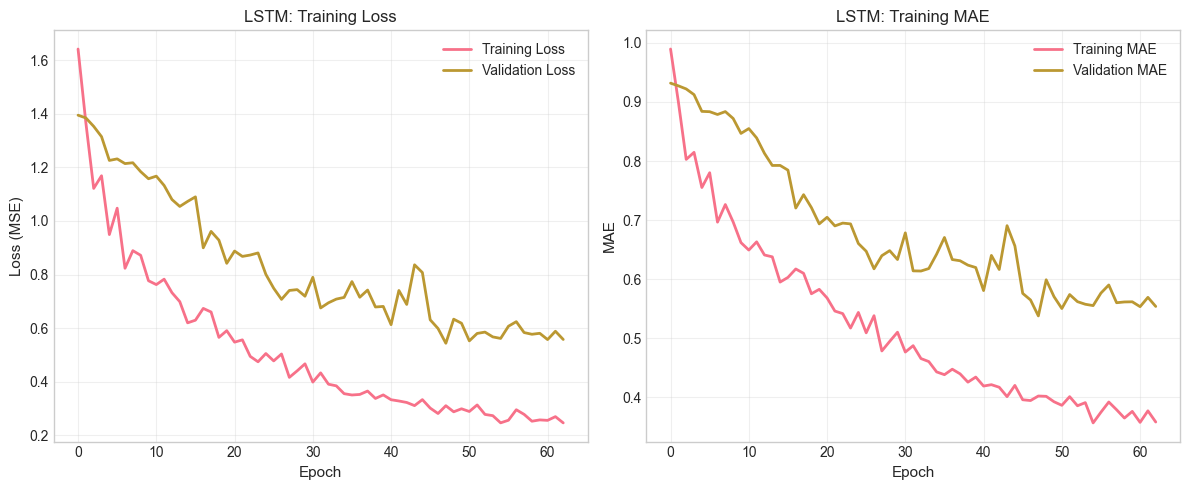

In [29]:
# Plot training history
fig = plot_training_history(history, model_name='LSTM')
plt.show()

## 4. Model Evaluation

In [30]:
# Make predictions
y_pred_train = lstm_model.predict(X_train)
y_pred_val = lstm_model.predict(X_val)
y_pred_test = lstm_model.predict(X_test)

# Inverse transform to original scale
y_train_orig = inverse_transform_predictions(y_train, data['target_scaler'])
y_val_orig = inverse_transform_predictions(y_val, data['target_scaler'])
y_test_orig = inverse_transform_predictions(y_test, data['target_scaler'])

y_pred_train_orig = inverse_transform_predictions(y_pred_train, data['target_scaler'])
y_pred_val_orig = inverse_transform_predictions(y_pred_val, data['target_scaler'])
y_pred_test_orig = inverse_transform_predictions(y_pred_test, data['target_scaler'])

In [31]:
# Evaluate on all sets
print("="*60)
print("LSTM MODEL EVALUATION RESULTS")
print("="*60)

# Training set
train_metrics = evaluate_model(y_train_orig, y_pred_train_orig, 'LSTM-Train')
print(f"\nTraining Set:")
print(f"  RMSE: {train_metrics['rmse']:.4f}")
print(f"  MAE:  {train_metrics['mae']:.4f}")
print(f"  R²:   {train_metrics['r2']:.4f}")

# Validation set
val_metrics = evaluate_model(y_val_orig, y_pred_val_orig, 'LSTM-Val')
print(f"\nValidation Set:")
print(f"  RMSE: {val_metrics['rmse']:.4f}")
print(f"  MAE:  {val_metrics['mae']:.4f}")
print(f"  R²:   {val_metrics['r2']:.4f}")

# Test set
test_metrics = evaluate_model(y_test_orig, y_pred_test_orig, 'LSTM-Test',
                               training_time=lstm_model.training_time)
print(f"\nTest Set:")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE:  {test_metrics['mae']:.4f}")
print(f"  R²:   {test_metrics['r2']:.4f}")

print(f"\nTraining Time: {lstm_model.training_time:.2f} seconds")
print("="*60)

LSTM MODEL EVALUATION RESULTS

Training Set:
  RMSE: 2.4864
  MAE:  1.7499
  R²:   0.8741

Validation Set:
  RMSE: 5.0709
  MAE:  3.7563
  R²:   0.5988

Test Set:
  RMSE: 4.9747
  MAE:  3.6674
  R²:   0.6168

Training Time: 34.55 seconds


## 5. Visualizations

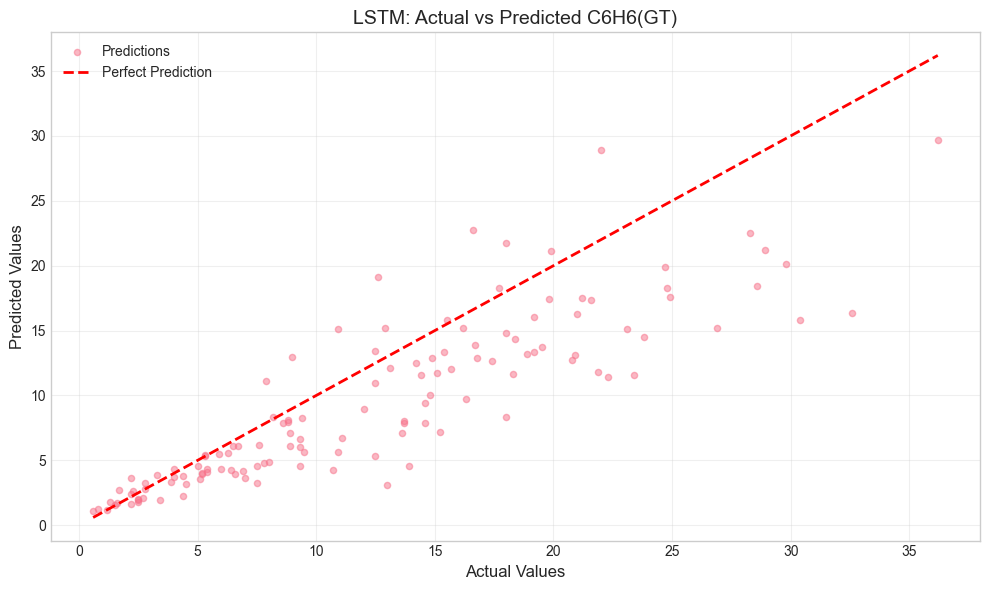

In [32]:
# Actual vs Predicted plot
fig = plot_actual_vs_predicted(
    y_test_orig, y_pred_test_orig,
    model_name='LSTM',
    title=f'LSTM: Actual vs Predicted {TARGET_COLUMN}'
)
plt.show()

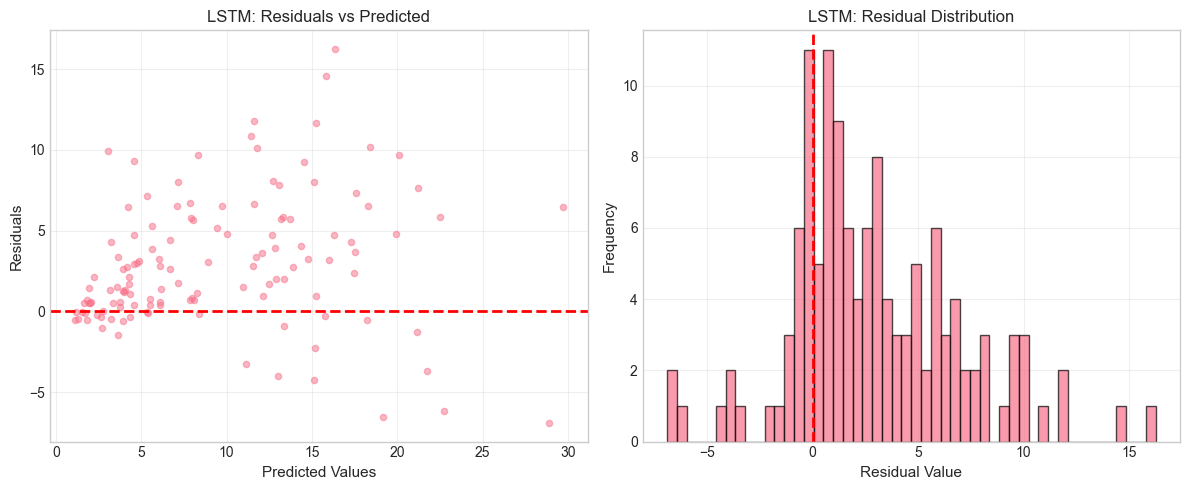

In [33]:
# Residual analysis
fig = plot_residuals(y_test_orig, y_pred_test_orig, model_name='LSTM')
plt.show()

Plotting last 127 test samples (total test samples: 127)


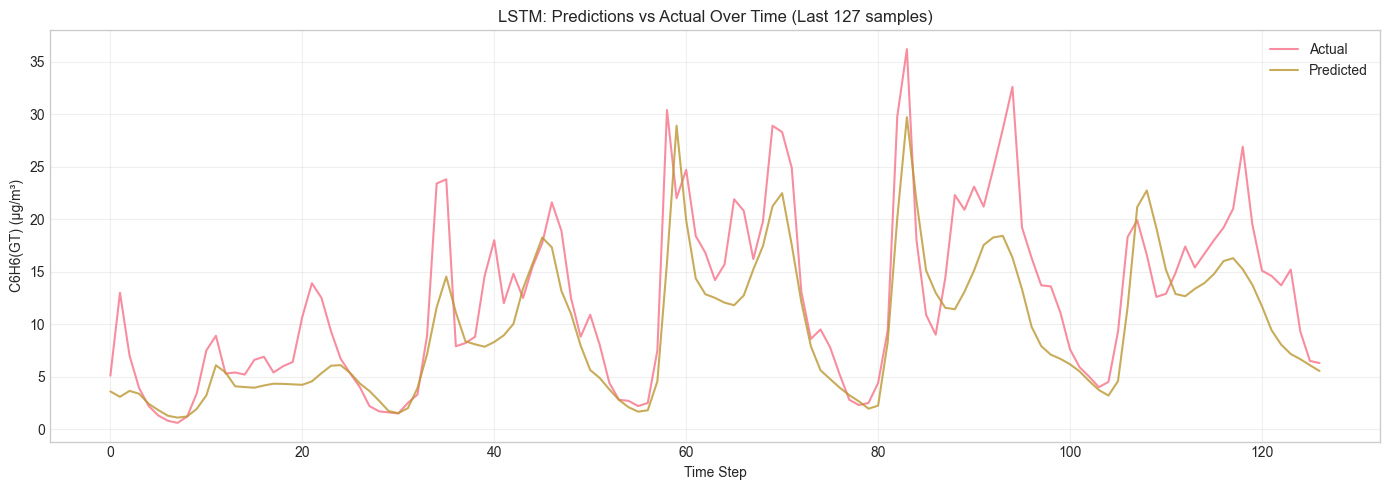

In [34]:
# Predictions over time (fixed to handle small test sets)
n_points = min(200, len(y_test_orig))  # Don't exceed available data

print(f"Plotting last {n_points} test samples (total test samples: {len(y_test_orig)})")

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(range(n_points), y_test_orig[-n_points:], label='Actual', alpha=0.8, lw=1.5)
ax.plot(range(n_points), y_pred_test_orig[-n_points:], label='Predicted', alpha=0.8, lw=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel(f'{TARGET_COLUMN} (µg/m³)')
ax.set_title(f'LSTM: Predictions vs Actual Over Time (Last {n_points} samples)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Save Results

In [35]:
# Compile results
lstm_results = {
    'model_type': 'LSTM',
    'model_config': MODEL_CONFIG,
    'train_config': TRAIN_CONFIG,
    'sequence_length': SEQUENCE_LENGTH,
    'metrics': {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    },
    'training_time': lstm_model.training_time,
    'history': history,
    'predictions': {
        'test_actual': y_test_orig.tolist(),
        'test_predicted': y_pred_test_orig.tolist()
    }
}

# Save to JSON
save_results_to_json(lstm_results, '../results/lstm_results.json')

print("Results saved successfully!")

[INFO] Results saved to ../results/lstm_results.json
Results saved successfully!


## 7. Summary and Discussion

### LSTM vs ANN Baseline:

| Aspect | ANN | LSTM |
|--------|-----|------|
| Input | Single time point | Sequence of 24 hours |
| Temporal awareness | None | Yes (gating mechanism) |
| Parameters | Fewer | More (recurrent weights) |
| Training time | Faster | Slower |

### Key Observations:
1. **Temporal Modeling**: LSTM can capture daily patterns (rush hours, night dip)
2. **Sequence Context**: Using 24 hours of history provides richer context
3. **Training Complexity**: More epochs may be needed for convergence

### When LSTM is Better:
- When temporal patterns are strong
- When past values are predictive of future
- When sequence context matters

### When ANN Might Be Sufficient:
- When relationships are primarily instantaneous
- When training speed is critical
- When sequence data is not available

In [36]:
# Final summary
print("\n" + "="*60)
print("LSTM MODEL SUMMARY")
print("="*60)
print(f"Sequence Length: {SEQUENCE_LENGTH} time steps")
print(f"LSTM Architecture: {MODEL_CONFIG['lstm_layers']}")
print(f"Dense Layers: {MODEL_CONFIG['dense_layers']}")
print(f"Test RMSE: {test_metrics['rmse']:.4f}")
print(f"Test MAE: {test_metrics['mae']:.4f}")
print(f"Test R²: {test_metrics['r2']:.4f}")
print(f"Training Time: {lstm_model.training_time:.2f}s")
print("="*60)


LSTM MODEL SUMMARY
Sequence Length: 12 time steps
LSTM Architecture: [64, 32]
Dense Layers: [32]
Test RMSE: 4.9747
Test MAE: 3.6674
Test R²: 0.6168
Training Time: 34.55s


## ⚙️ Configuration Summary for Fair Comparison

### All Models Use Consistent Settings:

| Parameter | ANN | LSTM | GA-ANN |
|-----------|-----|------|--------|
| **Epochs** | 100 | 100 | 50-150 (optimized) |
| **Batch Size** | 32 | 32 | 32 |
| **Hidden Layers** | [64, 32] | [64, 32] LSTM + [32] Dense | GA-optimized |
| **Dropout** | 0.2 | 0.2 | GA-optimized |
| **Early Stopping** | 15 | 15 | 15 |
| **Learning Rate** | 0.001 | 0.001 | GA-optimized |

This ensures **scientific validity** when comparing model performance!